In [1]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns

import rasterio
from rasterio.mask import mask
from rasterio.plot import show

# Decide Dry/Wet

In [2]:
# for each grid, if the sum of precipitation over the previous 14 days before a given day 
# is larger or equal to 1, the grid for that day is wet!

In [3]:
# only look at a smaller part of China *For Now* , since the bigger part is taking too long to be processed

nc_file_path = '/global/scratch/users/liuwenjin021011/data/CHIRPS/chirps-v2.0.2017.days_p05.nc'

# Entire China
lat_min, lat_max = 18, 54
lon_min, lon_max = 73, 135

ds = xr.open_dataset(nc_file_path)

ds_china = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
ds_china

<xarray.Dataset>
Dimensions:    (latitude: 640, longitude: 1240, time: 365)
Coordinates:
  * latitude   (latitude) float32 18.02 18.07 18.12 18.17 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 73.02 73.07 73.12 73.18 ... 134.9 134.9 135.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2018-01-17
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [4]:
# get the info of precip, NOTICE that precip is recored in mm/day, but the criteria for wet is 1cm!!!

def get_variable_info(dataset, variable_name):
    
    if variable_name in dataset.variables:
        variable = dataset[variable_name]
        unit = variable.attrs.get('units', 'No units attribute')
        description = variable.attrs.get('long_name', 'No description attribute')
        return unit, description
    else:
        return 'Variable not found in dataset', ''

unit, description = get_variable_info(ds_china, 'precip')
print(f"Unit: {unit}\nDescription: {description}")


Unit: mm/day
Description: Climate Hazards group InfraRed Precipitation with Stations


In [ ]:
# df with grid status as Wet/Dry
CHIRPS_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_F.csv')
CHIRPS_df.dropna(inplace = True)
CHIRPS_df = CHIRPS_df.reset_index()

CHIRPS_df.head(2)

In [ ]:
# FIX: Modify the temp unit from K to C
CHIRPS_df['temp'] = (CHIRPS_df['temp'] - 273.15)

In [ ]:
def plot_avg_precipitation(df, shapefile_path, column='avg_interpolated_precip', title='Year-Round Average Interpolated Precipitation', vmin=0, vmax=20):
    
    avg_precip_df = df.groupby(['lat', 'lon'])['interpolated_precip'].mean().reset_index()
    avg_precip_df.rename(columns={'interpolated_precip': 'avg_interpolated_precip'}, inplace=True)
    
    gdf = gpd.GeoDataFrame(avg_precip_df, geometry=gpd.points_from_xy(avg_precip_df.lon, avg_precip_df.lat))

    # Set the coordinate reference system (CRS) if known
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary
    
    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, column=column, cmap='Blues', legend=True, markersize=5, alpha=0.6, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'  # Update this path

test_df = CHIRPS_df[CHIRPS_df['time'] == CHIRPS_df['time'][0]]
plot_avg_precipitation(test_df, shapefile_path)

# plot_avg_precipitation(CHIRPS_df_2018, shapefile_path)
# plot_avg_precipitation(CHIRPS_df_2019, shapefile_path)

In [5]:
CHIRPS_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2017_F.csv')
CHIRPS_df_2018  = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2018_F.csv')
CHIRPS_df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_F.csv')


/tmp/ipykernel_48458/3982863034.py:54: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_wet_days_percentage_within_shape(CHIRPS_df, 2017, shapefile_path)


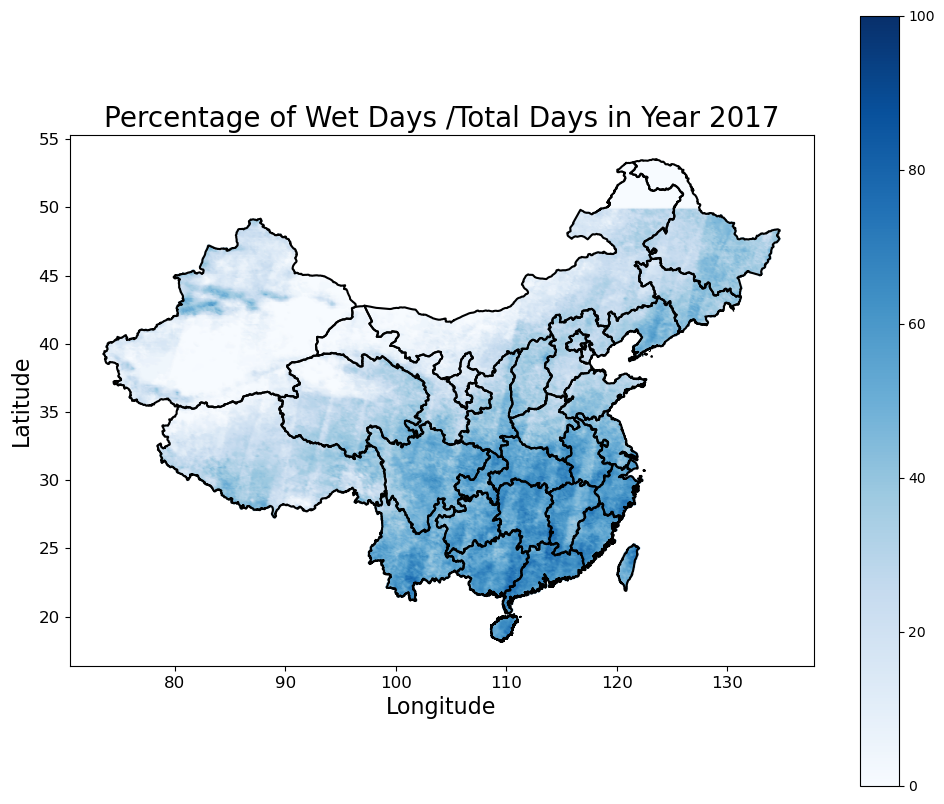

/tmp/ipykernel_48458/3982863034.py:55: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_wet_days_percentage_within_shape(CHIRPS_df_2018, 2018, shapefile_path)


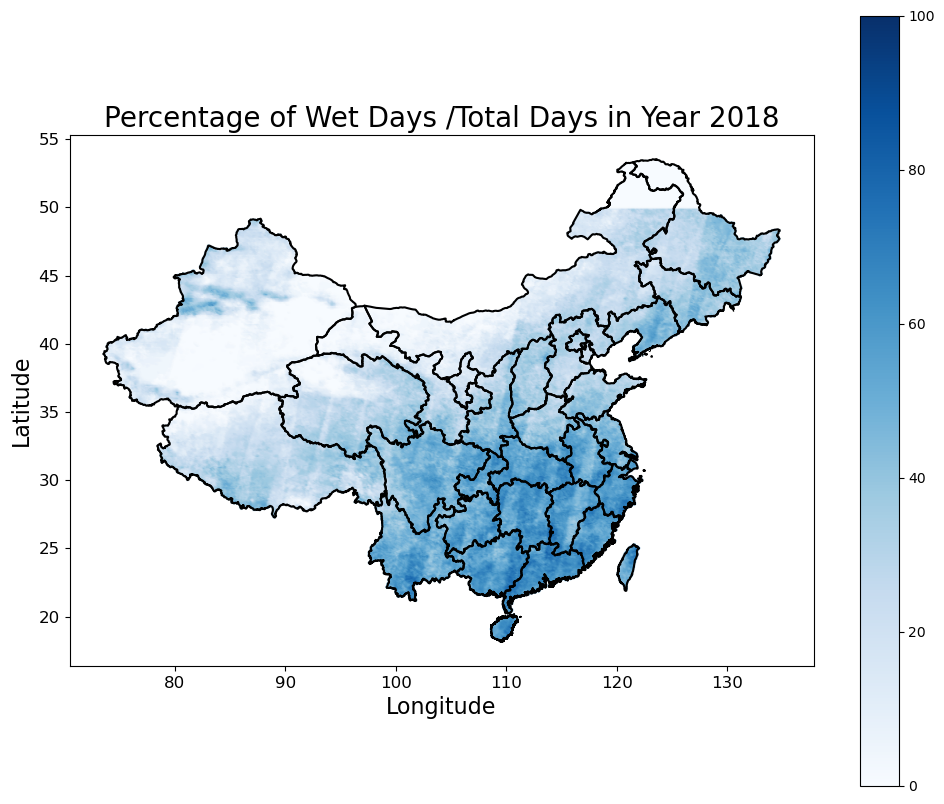

/tmp/ipykernel_48458/3982863034.py:56: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_wet_days_percentage_within_shape(CHIRPS_df_2019, 2019, shapefile_path)


In [ ]:
def filter_points_within_shape(df, shapefile_path, column='Factor_A'):
    wet_days_count = CHIRPS_df.groupby(['lat', 'lon'])['status'].apply(lambda x: (x == 'wet').sum())
    total_days_count = CHIRPS_df.groupby(['lat', 'lon'])['status'].count()
    wet_days_percentage = (wet_days_count / total_days_count) * 100
    percentage_df = wet_days_percentage.reset_index()
    percentage_df.rename(columns={'status': 'wet_days_percentage'}, inplace=True)
    avg_df = percentage_df

    # Convert df to a GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))

    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Perform spatial join to keep only points within the shapefile boundaries
    gdf_within_shape = gpd.sjoin(gdf, base_map, how="inner", op='intersects')

    # Drop the 'index_right' column if exists
    if 'index_right' in gdf_within_shape.columns:
        gdf_within_shape.drop(columns=['index_right'], inplace=True)

    return gdf_within_shape, base_map

def plot_wet_days_percentage_within_shape(df, year, shapefile_path):
    # Filter points to keep only those within the shapefile
    filtered_df, base_map = filter_points_within_shape(df, shapefile_path, 'Factor_A')

    # Determine the min and max values for the color scale
    vmax = 100 # int(filtered_df['avg_Factor_A'].max()) + 1
    vmin = 0  # Set minimum value

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)  # Plot the base map first with no fill color
    plot = filtered_df.plot(ax=ax, column='wet_days_percentage', cmap='Blues', legend=True, markersize=2, alpha=0.5, vmin=vmin, vmax=vmax)  # Then plot the data points
    base_map.boundary.plot(ax=ax, edgecolor='black')  # Plot the boundaries on top

    # Set larger font sizes
    title=f'Percentage of Wet Days /Total Days in Year {year}'
    plt.title(title, fontsize=20)  # Larger font size for the title
    plt.xlabel('Longitude', fontsize=16)  # Larger font size for the x-axis label
    plt.ylabel('Latitude', fontsize=16)  # Larger font size for the y-axis label
    plt.xticks(fontsize=12)  # Larger font size for the x-axis ticks
    plt.yticks(fontsize=12)  # Larger font size for the y-axis ticks

    plt.show()

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_wet_days_percentage_within_shape(CHIRPS_df, 2017, shapefile_path)
plot_wet_days_percentage_within_shape(CHIRPS_df_2018, 2018, shapefile_path)
plot_wet_days_percentage_within_shape(CHIRPS_df_2019, 2019, shapefile_path)

# Dry - Soil NOx Flux weak linear correlation with Soil Temp

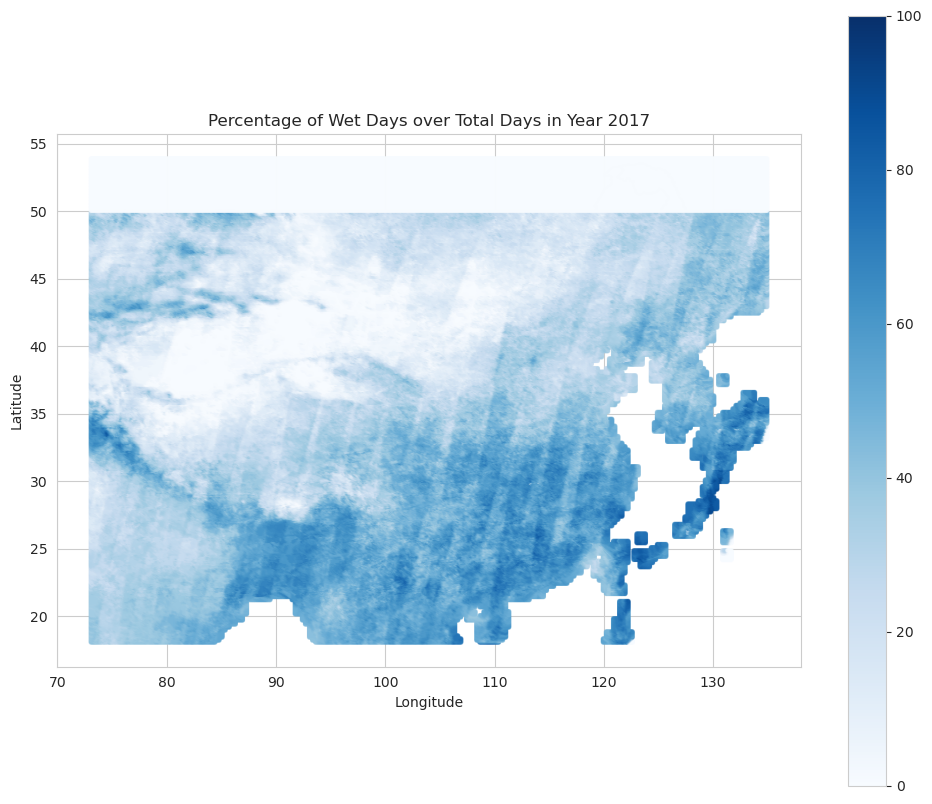

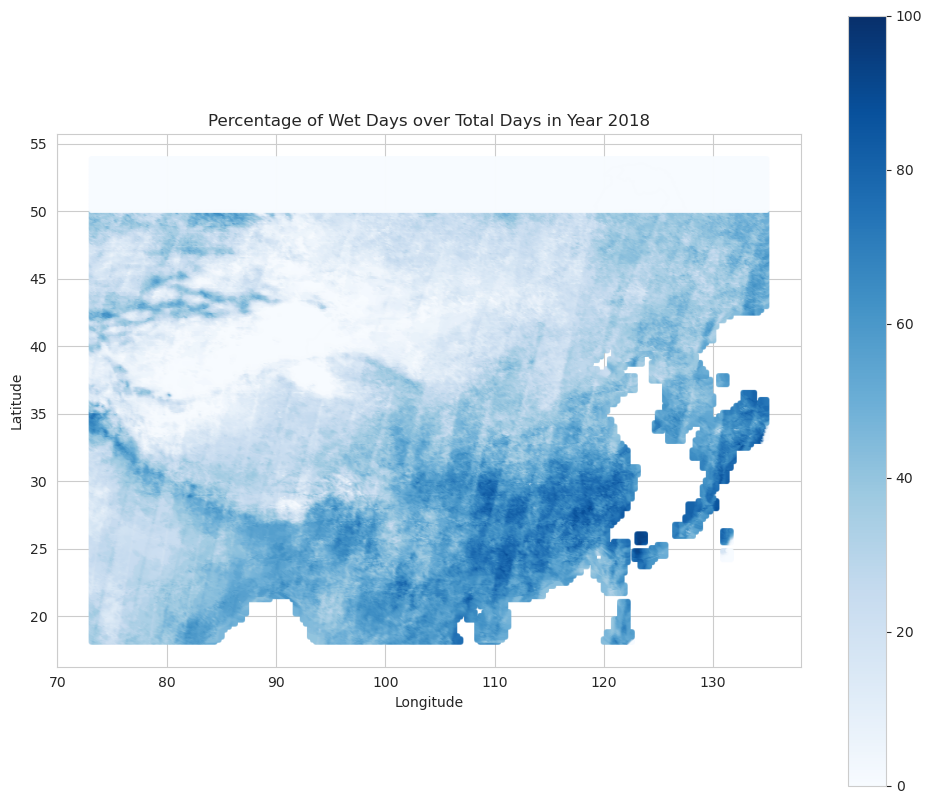

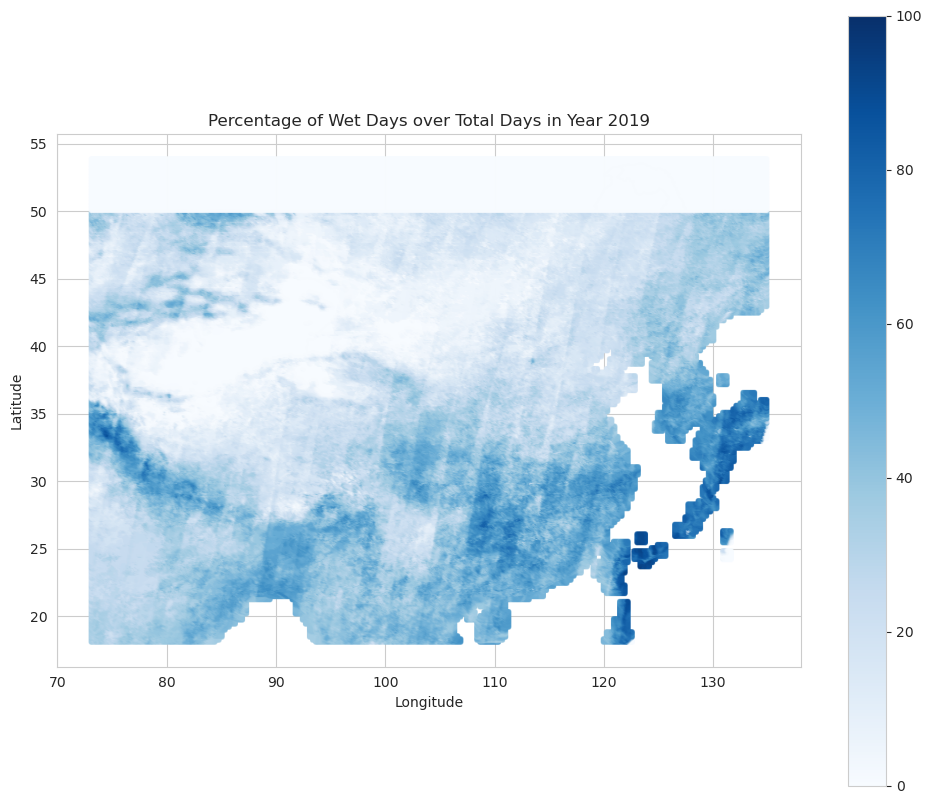

In [18]:
# Function to plot the data
def plot_wet_days_percentage(CHIRPS_df, year, shapefile_path, column='wet_days_percentage', ):
    
    # Calculate the count of 'wet' and 'total' days for each grid point
    wet_days_count = CHIRPS_df.groupby(['lat', 'lon'])['status'].apply(lambda x: (x == 'wet').sum())
    total_days_count = CHIRPS_df.groupby(['lat', 'lon'])['status'].count()

    # Calculate the percentage of wet days
    wet_days_percentage = (wet_days_count / total_days_count) * 100

    # Create a DataFrame from the calculated percentages
    percentage_df = wet_days_percentage.reset_index()
    percentage_df.rename(columns={'status': 'wet_days_percentage'}, inplace=True)

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        percentage_df, 
        geometry=gpd.points_from_xy(percentage_df.lon, percentage_df.lat)
    )

    # Set the coordinate reference system (CRS) if known
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    base_map = gpd.read_file(shapefile_path)
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, column=column, cmap='Blues', legend=True, markersize=5, alpha=0.6,  vmin=0, vmax=100)
    title= f'Percentage of Wet Days over Total Days in Year {year}'
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Load the shapefile
china_shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'  # Update this path
plot_wet_days_percentage(CHIRPS_df, 2017, china_shapefile_path)

plot_wet_days_percentage(CHIRPS_df_2018, 2018,  china_shapefile_path)
plot_wet_days_percentage(CHIRPS_df_2019, 2019, china_shapefile_path)

In [22]:


def Func_Dry(T, A_dry = 2.05):
    if T > 30:
        return A_dry
    # Count for the situation with Temp below zero as Temp = 0
    if T < 0:
        return 0
    else:
        return (A_dry * T) / 30

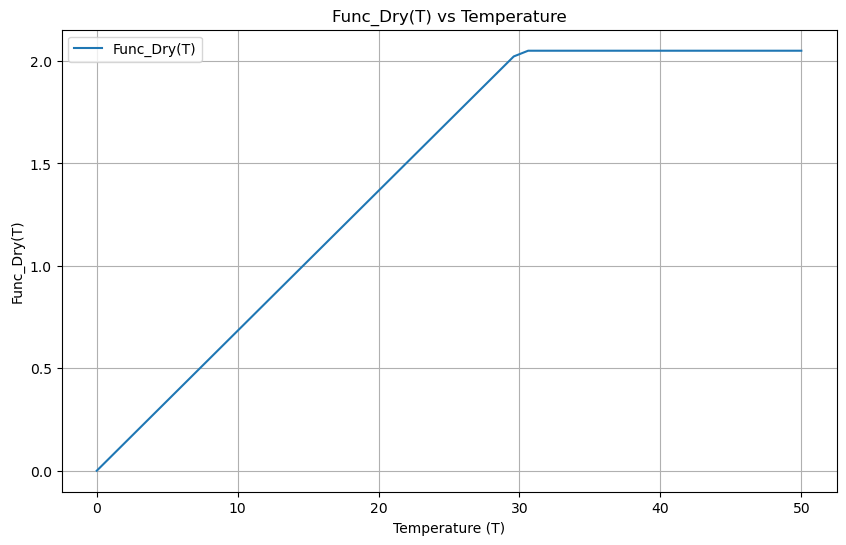

In [23]:
# Generate a range of T values from 0 to 50
T_values = np.linspace(0, 50)  # 500 points for smoother curve

# Apply Func_Wet to each T value
func_values = [Func_Dry(T) for T in T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(T_values, func_values, label='Func_Dry(T)')
plt.xlabel('Temperature (T)')
plt.ylabel('Func_Dry(T)')
plt.title('Func_Dry(T) vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Wet - Soil NOx Fluw Sensitive to Soil Temp

## A_Wet, biome Based on Revised Nitrogen Requirement Each Grid Each Month F

In [24]:
# A_wet_biome = A_wet_grassland + S * F, A_wet_grassland = 0.36, S = 2.5%

# For detailed info calculating Revised Nitrogen Reqirement Each Grid Each Month F
# Please check: ./Data Preprocessing 3 - Factor A CHIRPS F [Revised Nitrogen Requirement] Calculate

## Wet Function

In [16]:

def Func_Wet(T, F = 0, A_wet_grassland = 0.36, S = 2.5/100):
    A_wet_biome = A_wet_grassland + S * F
    
    # Count for the situation with Temp below zero as Temp = 0
    if T < 0:
        return 0
    if (T>=0) and (T<=10):
        return 0.28 * T  * A_wet_biome 
    if T<= 20:
        return  np.exp(0.103 * T)  * A_wet_biome 
    if T<= 40:
        return -0.009 * T**3 + 0.837 * T**2 - 22.527 * T + 196.149
    else:
        T = 40 
        return -0.009 * T**3 + 0.837 * T**2 - 22.527 * T + 196.149
    

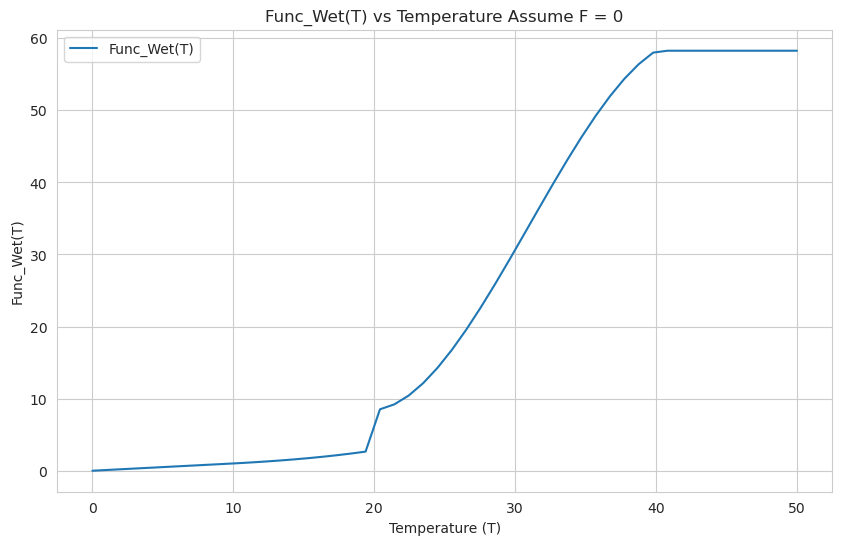

In [17]:
# Generate a range of T values from 0 to 50
T_values = np.linspace(0, 50)  # 500 points for smoother curve

# Apply Func_Wet to each T value
func_values = [Func_Wet(T) for T in T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(T_values, func_values, label='Func_Wet(T)')
plt.xlabel('Temperature (T)')
plt.ylabel('Func_Wet(T)')
plt.title('Func_Wet(T) vs Temperature Assume F = 0')
plt.legend()
plt.grid(True)
plt.show()

# Factor A

In [27]:
# NOTE: The N Requirement Each Grid Each Month is set to be 0 beofre the GFSAD1000 Dataset is fixed!

def Factor_A_Func(Status, T_In, F_In = 0):
    if Status == 'dry':
        return Func_Dry(T_In)
    if Status == 'wet':
        return Func_Wet(T_In, F = F_In)


In [28]:
test_df = CHIRPS_df[(CHIRPS_df['lat'] == CHIRPS_df['lat'][0]) & (CHIRPS_df['lon'] == CHIRPS_df['lon'][0])]

test_df['Factor_A'] = test_df.apply(lambda row: Factor_A_Func(row['status'], row['temp'], F_In=row['F [N Requirement]']), axis=1)
test_df

/tmp/ipykernel_23747/2582192743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Factor_A'] = test_df.apply(lambda row: Factor_A_Func(row['status'], row['temp'], F_In=row['F [N Requirement]']), axis=1)


,index,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement],Factor_A
0,0,0,20.513201,100.783195,0.000000,16.62620,2019-01-01,dry,"""[]""",0,1.136124
100856,100856,712145,20.513201,100.783195,0.000000,18.11627,2019-01-04,dry,"""[]""",0,1.237945
151295,151295,1052815,20.513201,100.783195,0.000000,19.95110,2019-01-06,dry,"""[]""",0,1.363325
198300,198300,1394431,20.513201,100.783195,5.028695,20.50506,2019-01-07,dry,"""[]""",0,1.401179
254762,254762,1789095,20.513201,100.783195,0.000000,20.32955,2019-01-09,dry,"""[]""",0,1.389186
...,...,...,...,...,...,...,...,...,...,...,...
8876213,8876213,2238887,20.513201,100.783195,0.000000,19.10015,2019-12-19,dry,"""[]""",0,1.305177
8978933,8978933,2967470,20.513201,100.783195,0.000000,19.13854,2019-12-22,dry,"""[]""",0,1.307800
9020548,9020548,3250614,20.513201,100.783195,0.000000,18.87820,2019-12-24,dry,"""[]""",0,1.290010
9060654,9060654,3539975,20.513201,100.783195,0.000000,19.11974,2019-12-25,dry,"""[]""",0,1.306516


In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

chunk_size = 10000000
start_chunk_index = 0
total_rows = CHIRPS_df.shape[0]
chunk_num = (total_rows + chunk_size - 1) // chunk_size

for chunk_index in np.arange(start_chunk_index, chunk_num):
    chunk_start = chunk_index * chunk_size
    chunk_end = min((chunk_index + 1) * chunk_size, total_rows)
    chunk_length = chunk_end - chunk_start

    # Initialize a new tqdm progress bar for the current chunk
    with tqdm(total=chunk_length, desc=f"Processing Chunk {chunk_index+1}/{chunk_num}") as chunk_bar:
        chunk_df = CHIRPS_df.iloc[chunk_start:chunk_end]
        
        # Using apply() directly does not allow us to update the progress bar, so we'll use a for loop
        for i, row in chunk_df.iterrows():
            # Update 'Factor_A' for each row here (simplified for brevity)
            chunk_df.at[i, 'Factor_A'] = Factor_A_Func(row['status'], row['temp'], F_In=row['F [N Requirement]'])
            chunk_bar.update(1)  # Update the progress bar by one for each row processed

        chunk_df.to_csv(f'/global/scratch/users/liuwenjin021011/data/ThesisFactorA/FactorA_Updated_With_F_Year2019_Chunk{chunk_index}.csv', index=False, header=True)


Processing Chunk 1/4:   0%|          | 0/10000000 [00:00<?, ?it/s]/tmp/ipykernel_23747/2803045543.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df.at[i, 'Factor_A'] = Factor_A_Func(row['status'], row['temp'], F_In=row['F [N Requirement]'])
Processing Chunk 2/4:   0%|          | 0/10000000 [00:00<?, ?it/s]/tmp/ipykernel_23747/2803045543.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df.at[i, 'Factor_A'] = Factor_A_Func(row['status'], row['temp'], F_In=row['F [N Requirement]'])
Proces

In [30]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/FactorA_Updated_With_F_Year2019_Chunk0.csv')

In [31]:
df[(df['F [N Requirement]'] > 0) & (df['status'] != 'dry')]

,index,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement],Factor_A


## Factor A Visualization

In [32]:
files = []
path = '/global/scratch/users/liuwenjin021011/data/ThesisFactorA/'
for file in os.listdir(path):
    if 'FactorA_Updated_With_F_Year2019' in file:
        files += [path + file]

In [33]:
def merge_file(file_list, save_name):
    all_df = pd.DataFrame()
    for file in file_list:
        chunk_df = pd.read_csv(file)
        all_df = pd.concat([all_df, chunk_df])
    
    all_df = all_df.drop_duplicates()
    all_df.to_csv(f'/global/scratch/users/liuwenjin021011/data/FactorA_DONE_Year_{save_name}.csv')

In [34]:
merge_file(files, '2019')

In [2]:
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_DONE_Year_2017.csv')

df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_DONE_Year_2018.csv')

df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_DONE_Year_2019.csv')

/tmp/ipykernel_51531/3031672234.py:51: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2017, 2017, shapefile_path)


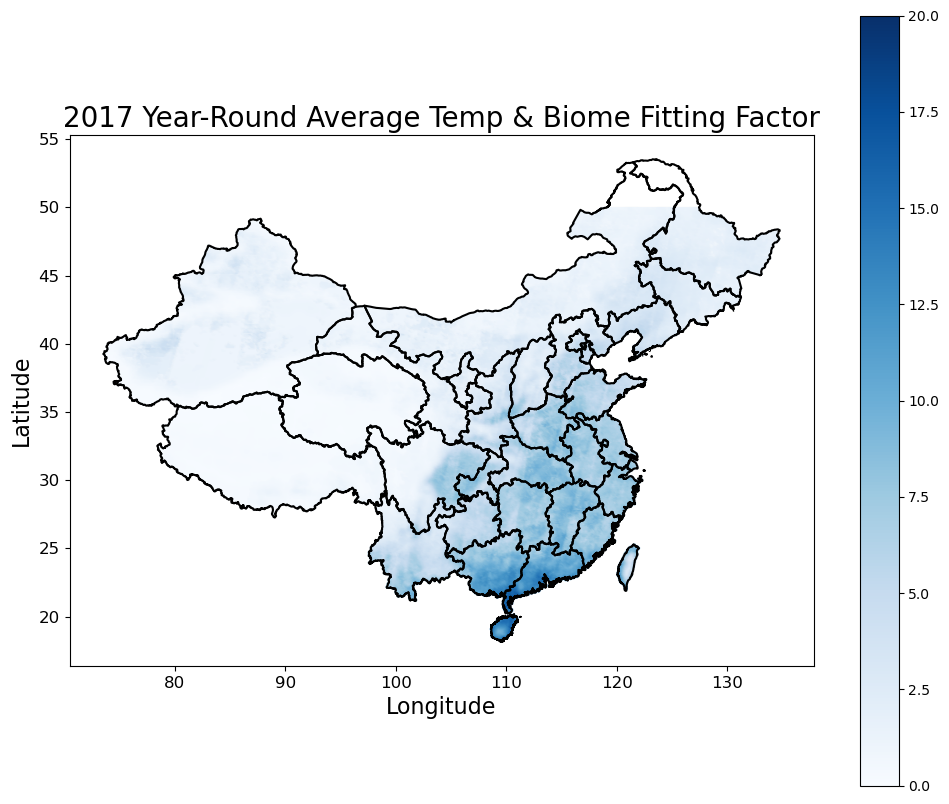

/tmp/ipykernel_51531/3031672234.py:53: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2018, 2018, shapefile_path)


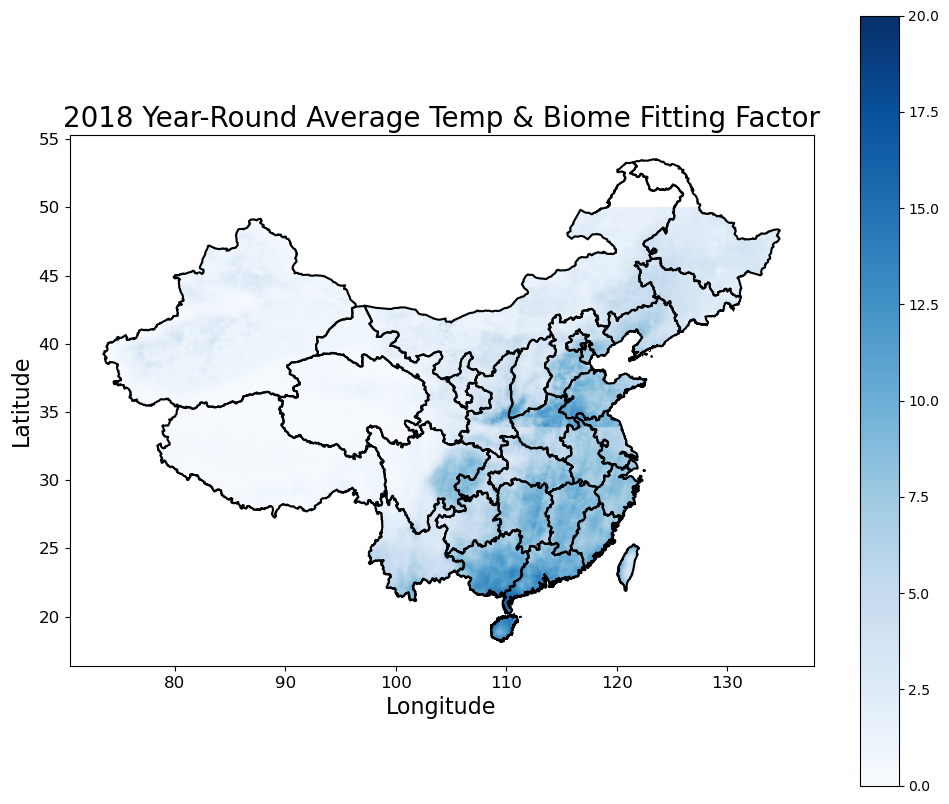

/tmp/ipykernel_51531/3031672234.py:54: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2019, 2019, shapefile_path)


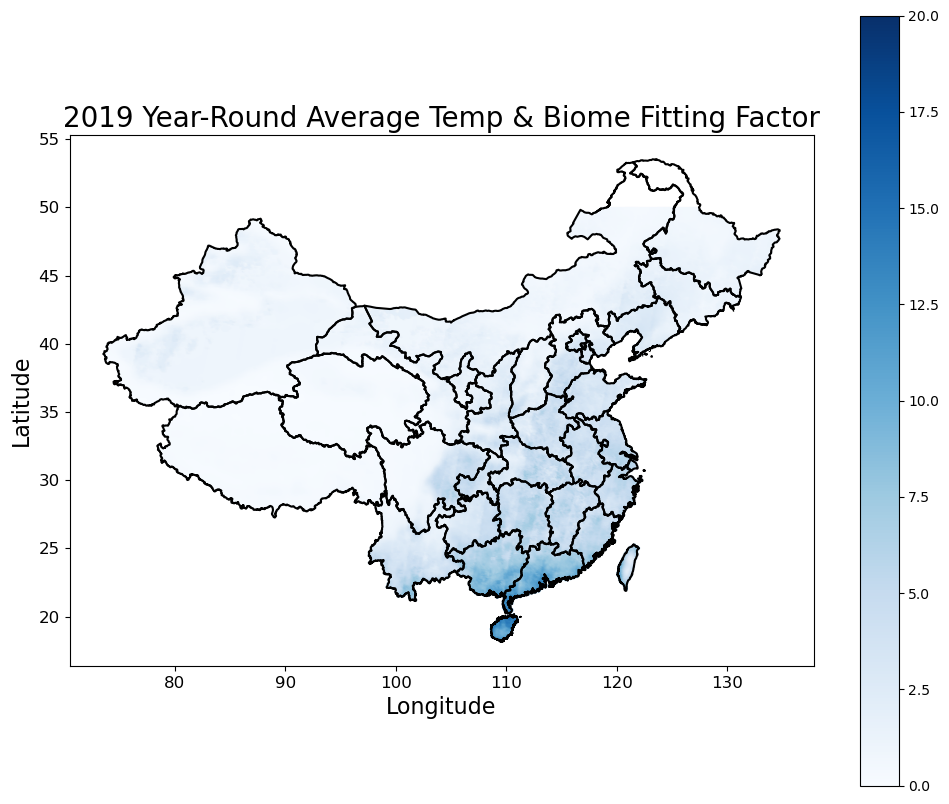

In [3]:
def filter_points_within_shape(df, shapefile_path, column='Factor_A'):
    # Compute the average of the column of interest
    avg_df = df.groupby(['lat', 'lon'])[column].mean().reset_index()
    avg_df.rename(columns={column: 'avg_Factor_A'}, inplace=True)

    # Convert df to a GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))

    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Perform spatial join to keep only points within the shapefile boundaries
    gdf_within_shape = gpd.sjoin(gdf, base_map, how="inner", op='intersects')

    # Drop the 'index_right' column if exists
    if 'index_right' in gdf_within_shape.columns:
        gdf_within_shape.drop(columns=['index_right'], inplace=True)

    return gdf_within_shape, base_map

def plot_Biome_Fitting_within_shape(df,year, shapefile_path, ):
    # Filter points to keep only those within the shapefile
    filtered_df, base_map = filter_points_within_shape(df, shapefile_path, 'Factor_A')

    # Determine the min and max values for the color scale
    vmax = 20 # int(filtered_df['avg_Factor_A'].max()) + 1
    vmin = 0  # Set minimum value

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)  # Plot the base map first with no fill color
    plot = filtered_df.plot(ax=ax, column='avg_Factor_A', cmap='Blues', legend=True, markersize=2, alpha=0.5, vmin=vmin, vmax=vmax)  # Then plot the data points
    base_map.boundary.plot(ax=ax, edgecolor='black')  # Plot the boundaries on top

    # Set larger font sizes
    title=f'{year} Year-Round Average Temp & Biome Fitting Factor'
    plt.title(title, fontsize=20)  # Larger font size for the title
    plt.xlabel('Longitude', fontsize=16)  # Larger font size for the x-axis label
    plt.ylabel('Latitude', fontsize=16)  # Larger font size for the y-axis label
    plt.xticks(fontsize=12)  # Larger font size for the x-axis ticks
    plt.yticks(fontsize=12)  # Larger font size for the y-axis ticks

    plt.show()

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_Biome_Fitting_within_shape(df_2017, 2017, shapefile_path)

plot_Biome_Fitting_within_shape(df_2018, 2018, shapefile_path)
plot_Biome_Fitting_within_shape(df_2019, 2019, shapefile_path)

In [29]:
df

,Unnamed: 0.3,index,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement],Factor_A,Unnamed: 0.2,Unnamed: 0.1
0,0,33609587,5280702.0,37.829597,121.135895,0.0,18.13925,2017-05-10,dry,[],0.000000,1.239515,NaN,NaN
1,1,33609588,5280710.0,37.829597,122.256226,0.0,16.38366,2017-05-10,dry,[],0.000000,1.119550,NaN,NaN
2,2,33609589,5280715.0,37.829597,122.442947,0.0,16.24080,2017-05-10,dry,[],0.000000,1.109788,NaN,NaN
3,3,33609590,5280722.0,37.829597,122.349586,0.0,16.29235,2017-05-10,dry,[],0.000000,1.113311,NaN,NaN
4,4,33609591,5280727.0,38.007710,116.281120,0.0,22.69360,2017-05-10,dry,"[""Rice"", ""Orchards"", ""Cotton"", ""Wheat""]",54.929835,1.550729,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32919685,9999995,52958880,9785771.0,41.385147,99.756226,0.0,20.33035,2018-05-20,dry,[],0.000000,1.389241,5046507.0,5046507.0
32919686,9999996,52958881,9785773.0,41.385147,99.662865,0.0,20.13137,2018-05-20,dry,[],0.000000,1.375644,5046508.0,5046508.0
32919687,9999997,52958882,9785775.0,41.385147,99.569504,0.0,19.89834,2018-05-20,dry,[],0.000000,1.359720,5046509.0,5046509.0
32919688,9999998,52958883,9785776.0,41.385147,99.476143,0.0,19.63214,2018-05-20,dry,[],0.000000,1.341530,5046510.0,5046510.0
